In [659]:
import os
import torch
import pandas as pd
import seaborn as sns
from pprint import pprint
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

In [642]:
students_mat = pd.read_csv(os.path.join('data', 'student-mat.csv'))
students_por = pd.read_csv(os.path.join('data', 'student-por.csv'))

In [643]:
students = pd.concat([students_mat, students_por], axis=0)

In [644]:
students['alc'] = students['Walc'] + students['Dalc']
students = students.drop(columns=['Walc', 'Dalc'])

In [645]:
numeric_cols = ['school',
                'age',
                'traveltime',
                'studytime',
                'failures',
                'famrel',
                'freetime',
                'goout',
                'health',
                'absences',
                'G1',
                'G2',
                'G3']
students = students.drop(columns=numeric_cols)

In [646]:
students.head(5)

,sex,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,alc
0,F,U,GT3,A,4,4,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no,2
1,F,U,GT3,T,1,1,at_home,other,course,father,no,yes,no,no,no,yes,yes,no,2
2,F,U,LE3,T,1,1,at_home,other,other,mother,yes,no,yes,no,yes,yes,yes,no,5
3,F,U,GT3,T,4,2,health,services,home,mother,no,yes,yes,yes,yes,yes,yes,yes,2
4,F,U,GT3,T,3,3,other,other,home,father,no,yes,yes,no,yes,yes,no,no,3


In [647]:
categorical_dict = {}
for col in students.columns:
    if students[col].dtype == 'O':
        le = LabelEncoder() 
        students[col] = le.fit_transform(students[col])
        categorical_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))

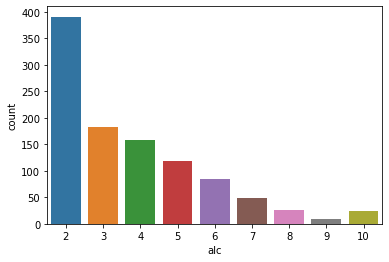

In [648]:
sns.countplot(students['alc'])

In [649]:
students.loc[students['alc'] <= 3, 'alc'] = 0
students.loc[(students['alc'] > 3) & (students['alc'] <= 5), 'alc'] = 1
students.loc[students['alc'] > 5, 'alc'] = 2

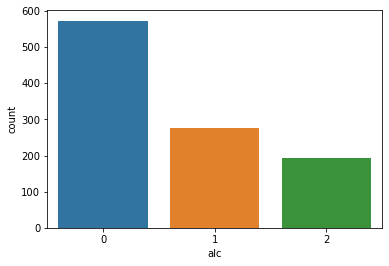

In [650]:
sns.countplot(students['alc'])

In [651]:
categorical_dict['alc'] = {'low' : 1, 'medium': 2, 'high': 3}

In [652]:
pprint(categorical_dict)

{'Fjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'Mjob': {'at_home': 0, 'health': 1, 'other': 2, 'services': 3, 'teacher': 4},
 'Pstatus': {'A': 0, 'T': 1},
 'activities': {'no': 0, 'yes': 1},
 'address': {'R': 0, 'U': 1},
 'alc': {'high': 3, 'low': 1, 'medium': 2},
 'famsize': {'GT3': 0, 'LE3': 1},
 'famsup': {'no': 0, 'yes': 1},
 'guardian': {'father': 0, 'mother': 1, 'other': 2},
 'higher': {'no': 0, 'yes': 1},
 'internet': {'no': 0, 'yes': 1},
 'nursery': {'no': 0, 'yes': 1},
 'paid': {'no': 0, 'yes': 1},
 'reason': {'course': 0, 'home': 1, 'other': 2, 'reputation': 3},
 'romantic': {'no': 0, 'yes': 1},
 'schoolsup': {'no': 0, 'yes': 1},
 'sex': {'F': 0, 'M': 1}}


In [653]:
X = torch.from_numpy(students.iloc[:, :-1].values)
y = torch.from_numpy(students.iloc[:, -1].values)

In [654]:
class NaiveBayesClassifier(BaseEstimator):
    def __init__(self, offset=1):
        self.offset = offset
        pass
    
    def fit(self, X, y, **kwargs):
        size = X.shape[0]
        
        self.nb_features = X.shape[1]
        y_uvals = y.unique()
        self.nb_class = len(y_uvals)
        self.class_probs = y.bincount().float() / size
        
        features_maxvals = torch.zeros((self.nb_features,), dtype=torch.int32)
        for j in range(self.nb_features):
            features_maxvals[j] = X[:, j].max()
        
        cond_probs = [] 
        for i in range(self.nb_class):
            cond_probs.append([])
            idx = torch.where(y == y_uvals[i])[0]
            elts = X[idx]
            
            size_class = elts.shape[0]
            for j in range(self.nb_features):
                cond_probs[i].append([])
                for k in range(features_maxvals[j] + 1):
                    p_x_k = (torch.where(elts[:, j] == k)[0].shape[0] + self.offset) / size_class
                    cond_probs[i][j].append(p_x_k)
        self.cond_probs = cond_probs
        return 0
    
    def predict(self, X):
        if len(X.shape) == 1:
            X = X.unsqueeze(0)
        
        nb_samples = X.shape[0]
        pred_probs = torch.zeros((nb_samples, self.nb_class), dtype=torch.float32)
        for k in range(nb_samples):
            elt = X[k]
            for i in range(self.nb_class):
                pred_probs[k][i] = self.class_probs[i]
                prob_feature_per_class = self.cond_probs[i]
                for j in range(self.nb_features):
                    pred_probs[k][i] *= prob_feature_per_class[j][elt[j]]
        return pred_probs.argmax(dim=1)

In [662]:
nbc = NaiveBayesClassifier()

cross_val_score(nbc, X, y, cv=5, scoring='accuracy').mean()

0.5450680898049319

In [663]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

cross_val_score(mnb, X, y, cv=5, scoring='accuracy').mean()

0.5517252484357748